In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import matplotlib as mpl
mpl.rcParams["figure.facecolor"]
mpl.rcParams["axes.facecolor"]
mpl.rcParams["savefig.facecolor"]
# plt.style.use('ggplot')

'auto'

## Read in remote sensing snow data and explore

In [99]:
rs_data_folder = r'../data/remote_sensing/TimeSeries_thresholded'

threshold_list = []
alt_list = []
catchment_list = []

rs_dict = {}  # key: (catchment, threshold, altitude)

file_list = os.scandir(rs_data_folder)

for item in file_list:
    if item.is_file():  # Otherwise was getting ipython checkpoints too

        catchment = item.name.split('_')[0]
        threshold = int(item.name.split('_')[-3][3:])
        altitude = item.name.split('_')[-2]

        # Make list of unique names
        if catchment not in catchment_list:
            catchment_list.append(catchment)
        if threshold not in threshold_list:
            threshold_list.append(threshold)
        if altitude not in alt_list:
            alt_list.append(altitude)

        # Read data and add sum column for checking
        df = pd.read_csv(item, sep='\t', index_col=0, parse_dates=True)
        # df['Sum'] = df.sum(axis=1, min_count=2)

        # Add total snow cover (hopefully equal to bare ground 100-bare ground%)
        df['SumSnow'] = df[['WetSnow', 'DrySnow']].sum(axis=1, min_count=2)

        rs_dict[(catchment, threshold, altitude)] = df

print(rs_dict.keys())
df.tail()

dict_keys([('Maalselvfossen', 5, '0-500'), ('Divielva', 20, '0-2500'), ('Vassområde196', 10, '500-2500'), ('Maalselvfossen', 10, '0-2500'), ('Divielva', 5, '500-2500'), ('Divielva', 10, '0-500'), ('Olsborg', 10, '0-2500'), ('Olsborg', 5, '0-2500'), ('Vassområde196', 20, '0-500'), ('Olsborg', 20, '0-2500'), ('Maalselvfossen', 5, '0-2500'), ('Vassområde196', 10, '0-500'), ('Maalselvfossen', 20, '0-500'), ('Divielva', 10, '500-2500'), ('Olsborg', 10, '500-2500'), ('Olsborg', 20, '500-2500'), ('Vassområde196', 5, '0-500'), ('Divielva', 20, '0-500'), ('Olsborg', 5, '0-500'), ('Olsborg', 5, '500-2500'), ('Barduelva', 5, '0-2500'), ('Olsborg', 10, '0-500'), ('Vassområde196', 5, '0-2500'), ('Vassområde196', 20, '500-2500'), ('Vassområde196', 20, '0-2500'), ('Maalselvfossen', 5, '500-2500'), ('Vassområde196', 10, '0-2500'), ('Barduelva', 10, '0-500'), ('Barduelva', 5, '0-500'), ('Divielva', 5, '0-2500'), ('Divielva', 5, '0-500'), ('Barduelva', 20, '0-2500'), ('Maalselvfossen', 10, '0-500'), ('M

,WetSnow,DrySnow,BareGround,SumSnow
Date,,,,
2022-08-19,NaN,NaN,NaN,NaN
2022-08-20,NaN,NaN,NaN,NaN
2022-08-21,NaN,NaN,NaN,NaN
2022-08-22,NaN,NaN,NaN,NaN
2022-08-23,NaN,NaN,NaN,NaN


### Quick plot

Text(0.5, 1.0, "('Maalselvfossen', 20, '0-2500')")

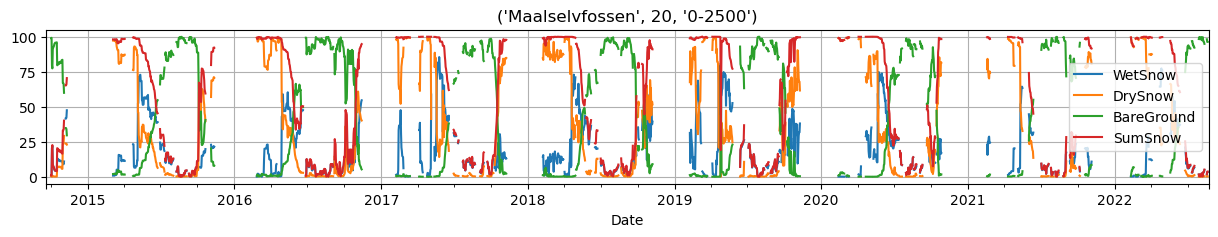

In [100]:
key = ('Maalselvfossen', 20, '0-2500')
df = rs_dict[key]
df.plot(subplots=False, figsize=(15, 2), grid=True, sharex=True, sharey=True);
plt.title(key)
# plt.savefig(r'../figures/snowcover/snowcover_ts.png')

This looks pretty good. The three series sum to 100% (within 0.001 dp), bare ground % increases steadily through spring and then decrease abruptly in winter, in early spring the % wet snow is low and % wet snow is high, then as the spring progresses the % dry snow generally decreases (with peaks), whilst % wet snow increases from low values in early spring to a peak (presumably during peak melt), then decreases to 0.

### Look at threshold vs NaNs

To make sure we're getting a good representation of what's going on in the catchment, Hannah has classed values as NaNs when the % of no data cells was less than a certain % of the whole catchment area. Thresholds included are 5%, 10% and 20%. i.e. under the 20% threshold, if >20% of the catchment cells have no data (e.g. due to cloud cover, shade, etc.) then values for all 3 columns (wet, dry, bare) are replaced with NaNs.

Lets take a quick look at what the choice of threshold means for the number of NaNs.

In [101]:
# s_list = []
# # Look at number of NaNs
# for key in rs_dict.keys():
#     nan_count = rs_dict[key].iloc[:,0].isna().sum()
#     s = pd.Series(data=list(key) + [nan_count], index=['Catchment', 'Threshold', 'Altitude', 'NaN_count'])
#     s_list.append(s)

# nan_df = pd.concat(s_list, axis=1).transpose().sort_values(['Catchment', 'Threshold', 'Altitude'])
# nan_df.head()

In [102]:
# grouped = nan_df.groupby(['Catchment'])

# ncols = 3
# nrows = 5 #int(np.ceil(grouped.ngroups/ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 8),
#                          sharey=True, sharex=True)
# axes = axes.flatten()

# # for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
# i = 0
# for key in grouped.groups.keys():
#     catch_grp = grouped.get_group(key)
#     alt_grouped = catch_grp.groupby('Altitude')
#     for key2 in alt_grouped.groups.keys():
#         alt_group = alt_grouped.get_group(key2)
#         ax = axes[i]
#         alt_group.plot.bar(x='Threshold', y='NaN_count', ax=ax)
#         ax.get_legend().remove()
#         ax.set_title("%s, %s" % (key, key2), size=10)
#         i = i+1
#     plt.ylim(ymin=1000)
# plt.suptitle('Number of NaNs at different discard thresholds')
# plt.tight_layout()
# plt.show()

**Generally:**
* The 0-500 altitude band has fewest NaNs and 500-2500 the most
* See a fairly linear relationship between the number of NaNs and the threshold for excluding data
* There's usually about a 40-50% increase in the number of NaNs when the threshold is reduced from 20% to 5% good cells. i.e. a big difference

**Decide to use 20%**

In [103]:
chosen_thresh = 20

## Interpolate to fill NaNs

Find that with a limit of 10 days, the number of NaNs is reduced by around 800-1000 (but varying depending on threshold and altitude band), reducing the NaNs by anything between 20%-50%'ish

In [104]:
nan_limit = 10

rs_dict_filled = {}

for j, key in enumerate(rs_dict.keys()):
    df = rs_dict[key]

    mask = df.copy()
    grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
    grp['ones'] = 1
    for i in df.columns:
        mask[i] = (grp.groupby(i)['ones'].transform('count') < nan_limit) | df[i].notnull()

    df_filled = df.interpolate(method='linear')[mask]

    # original_NaNs = df.isna().sum().sum()
    # end_NaNs = df_filled.isna().sum().sum()
    # print(f'{key}: {original_NaNs}, {end_NaNs}')

    # Put in new dict
    rs_dict_filled[key] = df_filled

## Read in Malangen fjord ice cover time series

The fjordice data is 1654 rows long, of which there were 216 duplicate indices (i.e. two values for the same date). For now, I will assume there were sometimes two satellite passes on the same day, and just average the two values. Note however that sometimes the two duplicates had really different values (e.g. 0.8 or 5.4 km2 ice coverage, which is large given the max value observed is around 9). This suggests real dodgyness in the ice data.

In addition, the ice data is extremely patchy in 2015 and 2016, so I will drop values before autumn 2017, and finnish in spring 2021.

<AxesSubplot:xlabel='Date'>

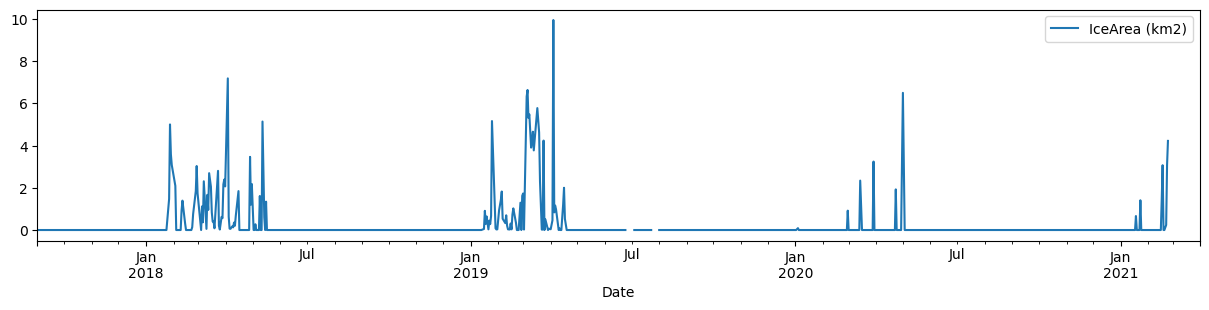

In [105]:
fjordice_df = pd.read_csv(r'../data/remote_sensing/Maalselv_fjordicearea.txt',
                          sep='\t', index_col=0, parse_dates=True)

# Sort out duplicate values
fjordice_duplicates = fjordice_df.loc[fjordice_df.index.duplicated(keep=False)]
fjordice_df = fjordice_df.resample('D').mean()

# Cut to just the more reliable time period
fjordice_df = fjordice_df.loc['2017-09-01': '2021-03-31', :]

# Interpolate to fill short gaps
nan_limit = 5
mask = fjordice_df.copy()
grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
grp['ones'] = 1
for i in fjordice_df.columns:
    mask[i] = (grp.groupby(i)['ones'].transform('count') < nan_limit) | fjordice_df[i].notnull()

fjordice_df = fjordice_df.interpolate(method='linear')[mask]

# Quick plot
fjordice_df.plot(figsize=(15, 3))

## Read in Målselvfossen discharge and FDOM data and join to snow data

### Discharge

In [106]:
q_fpath = r'../../data/discharge/Q_målselvfossen_alldata_daily-resolution_downloaded-2022-10.csv'
q_df = pd.read_csv(q_fpath, index_col=0, parse_dates=True)
q_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,value,unit,correction,quality
datetime,,,,,,,,,,
1965-03-23 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,17.53410,m³/s,1,3
1965-03-24 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,17.09777,m³/s,1,3
1965-03-25 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,16.66732,m³/s,1,3
1965-03-26 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,16.38360,m³/s,2,3
1965-03-27 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,16.10248,m³/s,2,3


In [107]:
# Tidy
# q_df.index = q_df.index.date  # Drop time info (mean applies to day centred on 11:00?)
q_df.rename(columns={'value': 'Q'}, inplace=True)
q_df = q_df['Q']
q_df.index = pd.to_datetime(q_df.index.tz_localize(None).date)
q_df.head()

1965-03-23    17.53410
1965-03-24    17.09777
1965-03-25    16.66732
1965-03-26    16.38360
1965-03-27    16.10248
Name: Q, dtype: float64

### Sensor data

In [108]:
fpath = r'../data/sensor_Malselva.csv'

sensor_df = pd.read_csv(fpath, index_col=1, parse_dates=True, na_values="NA")
sensor_df = sensor_df.drop('station_name', axis=1)
sensor_df.columns = ["FDOM", "Conductivity", "pH", "T_water", "Turbidity"]
sensor_df.dropna(how="all", axis=0, inplace=True)

# Resample to daily and drop timeaone info for joining
sensor_df = sensor_df.resample('D').mean()
sensor_df.index = sensor_df.index.tz_localize(None)

sensor_df.head()

,FDOM,Conductivity,pH,T_water,Turbidity
datetime,,,,,
2018-01-01,11.065417,4.930958,7.453875,0.005750,NaN
2018-01-02,10.982500,5.267292,7.446125,0.006167,NaN
2018-01-03,10.800000,5.097292,7.432292,0.005625,NaN
2018-01-04,10.571667,5.219750,7.435583,0.004958,NaN
2018-01-05,10.526667,4.797000,7.442167,0.004083,NaN


## Join all data and remove some dodgy snow data

Just use snow data for the whole Målselvfossen catchment for now.

In [109]:
# Make a dictionary with keys '0-500', '0-2500', '500-2500' (i.e. alt_list)
# joined discharge and snow data for the chosen threshold
join_dict = {}
for alt in alt_list:
    rs_df = rs_dict_filled['Maalselvfossen', chosen_thresh, alt]

    # Delete two dodgy points in the snow data and interpolate to fill resulting gap
    rs_df.loc[['2019-04-26', '2019-04-27'], :] = np.NaN
    rs_df.interpolate(method='linear', limit=2, inplace=True)

    # Join
    start_date = rs_df.index[0]
    joined_df = pd.concat([rs_df, q_df.loc[start_date:], sensor_df.loc[start_date:],
                           fjordice_df], axis=1)
    join_dict[alt] = joined_df

join_dict['0-500'].head()

,WetSnow,DrySnow,BareGround,SumSnow,Q,FDOM,Conductivity,pH,T_water,Turbidity,IceArea (km2)
2014-09-20,NaN,NaN,NaN,NaN,44.47170,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,NaN,NaN,NaN,NaN,50.41201,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-22,0.0,0.10040,99.90,0.10040,46.00612,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-23,0.0,0.03862,99.96,0.03862,42.46898,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24,0.0,0.03858,99.96,0.03858,40.33872,NaN,NaN,NaN,NaN,NaN,NaN


## Compare all data with snow data for Målselvfossen catchment

To do:

* Time series of wet snow and Q, maybe grouped by year
* Regression (with lag?) between the two?
* Does it make a difference when we split by altitude?

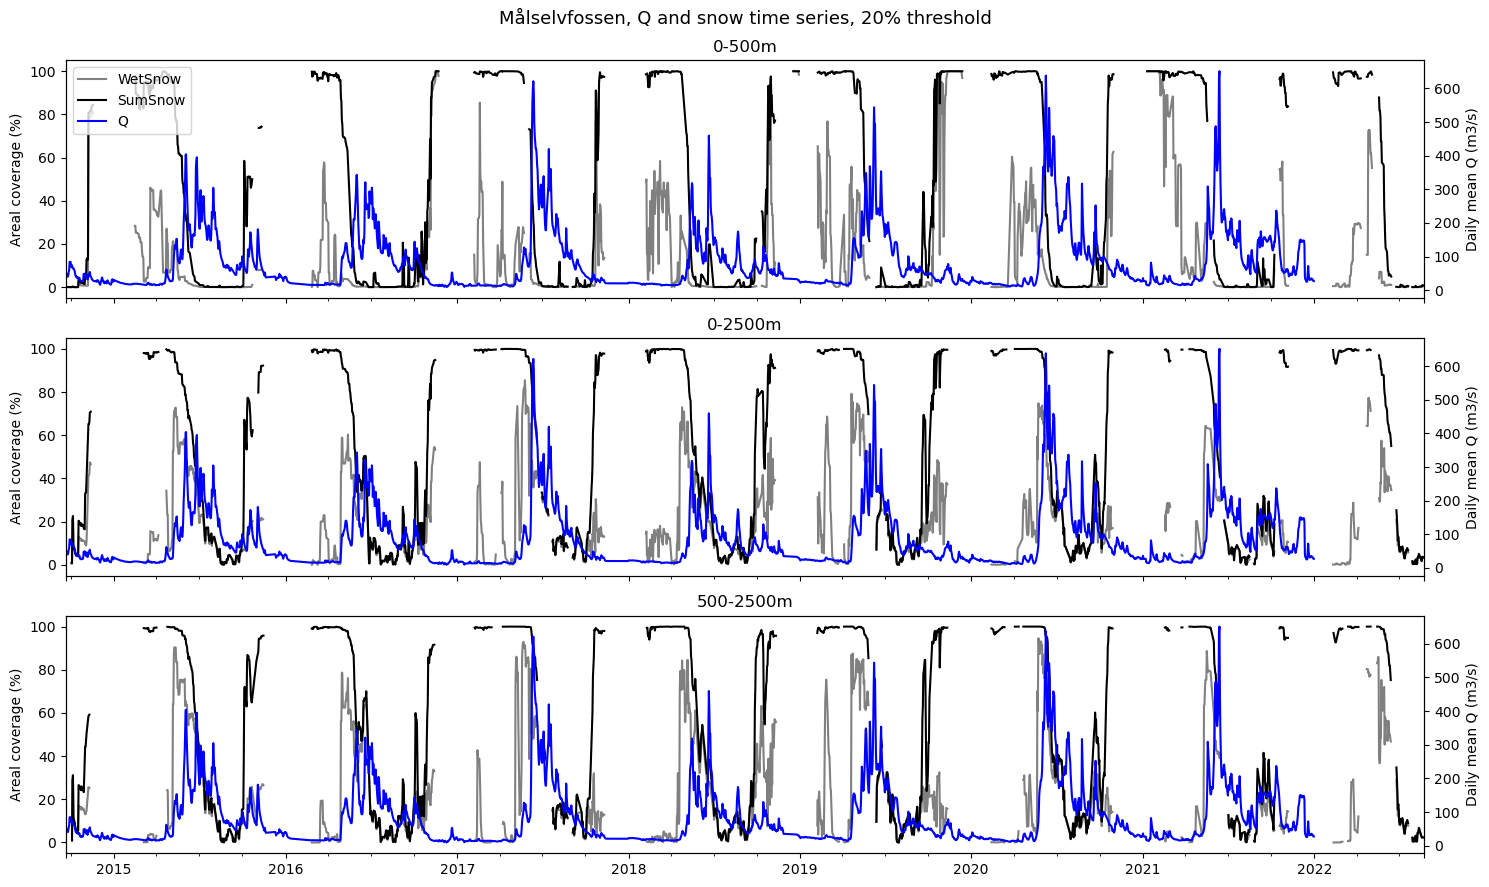

In [110]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True)

for i, band in enumerate(alt_list):

    df = join_dict[band]

    # Plot all years on one plot
    df[['WetSnow', 'SumSnow']].plot(figsize=(15, 9), color=['grey', 'black'],
                                               legend=False, ax=axs[i])
    ax2 = df['Q'].plot(secondary_y=True, color='b', ax=axs[i], mark_right=False)

    # Label axes
    axs[i].set_ylabel('Areal coverage (%)')
    ax2.set_ylabel('Daily mean Q (m3/s)')

    # Sort out the legend (complicated a bit by having the second axis)
    l1 = axs[i].get_lines()
    l2 = ax2.get_lines()
    lns = l1+l2
    labs = [l.get_label() for l in lns]

    if i==0:
        axs[i].legend(lns, labs, loc='upper left')

    axs[i].set_title(f'{band}m', size=12)

plt.suptitle(f"Målselvfossen, Q and snow time series, {chosen_thresh}% threshold", size=13)
plt.tight_layout()

plt.savefig(f"../figures/Målselvfossen_Q_{chosen_thresh}%_allyears.png")

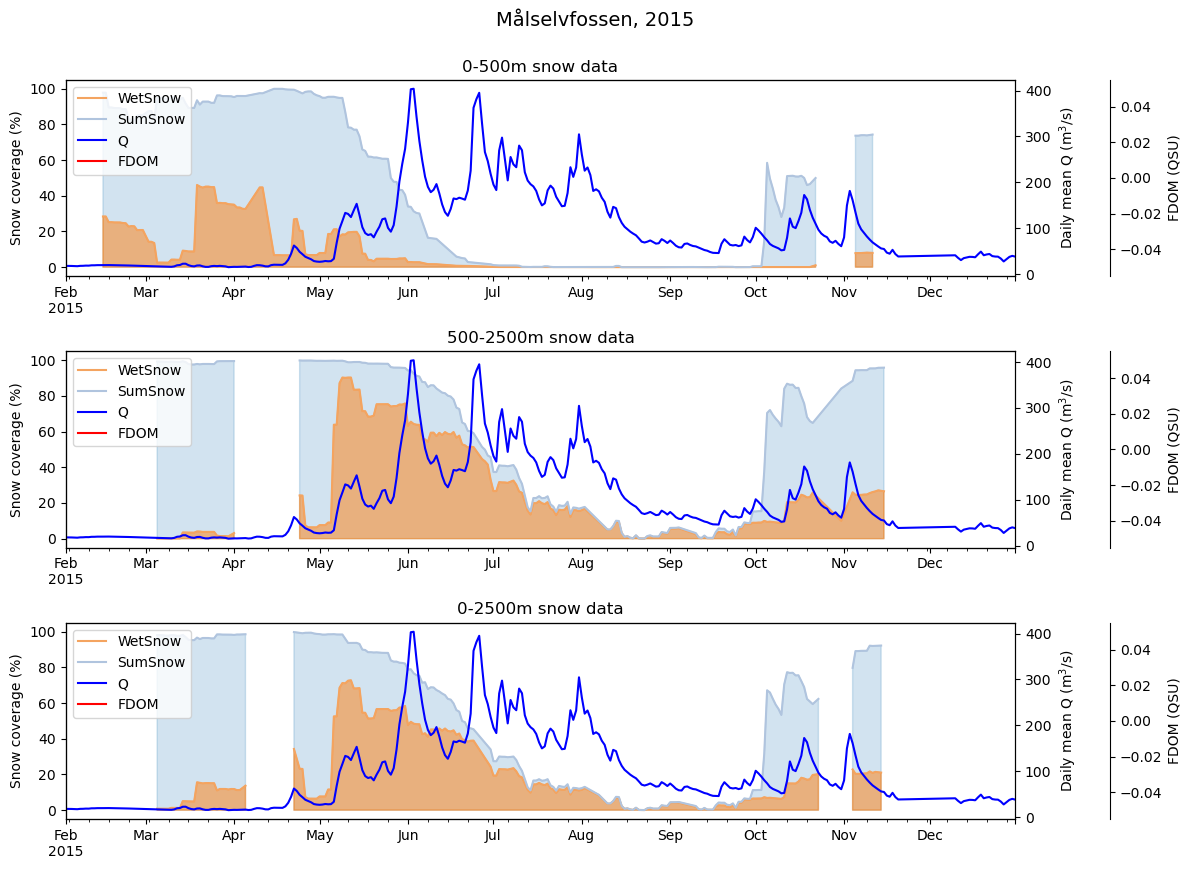

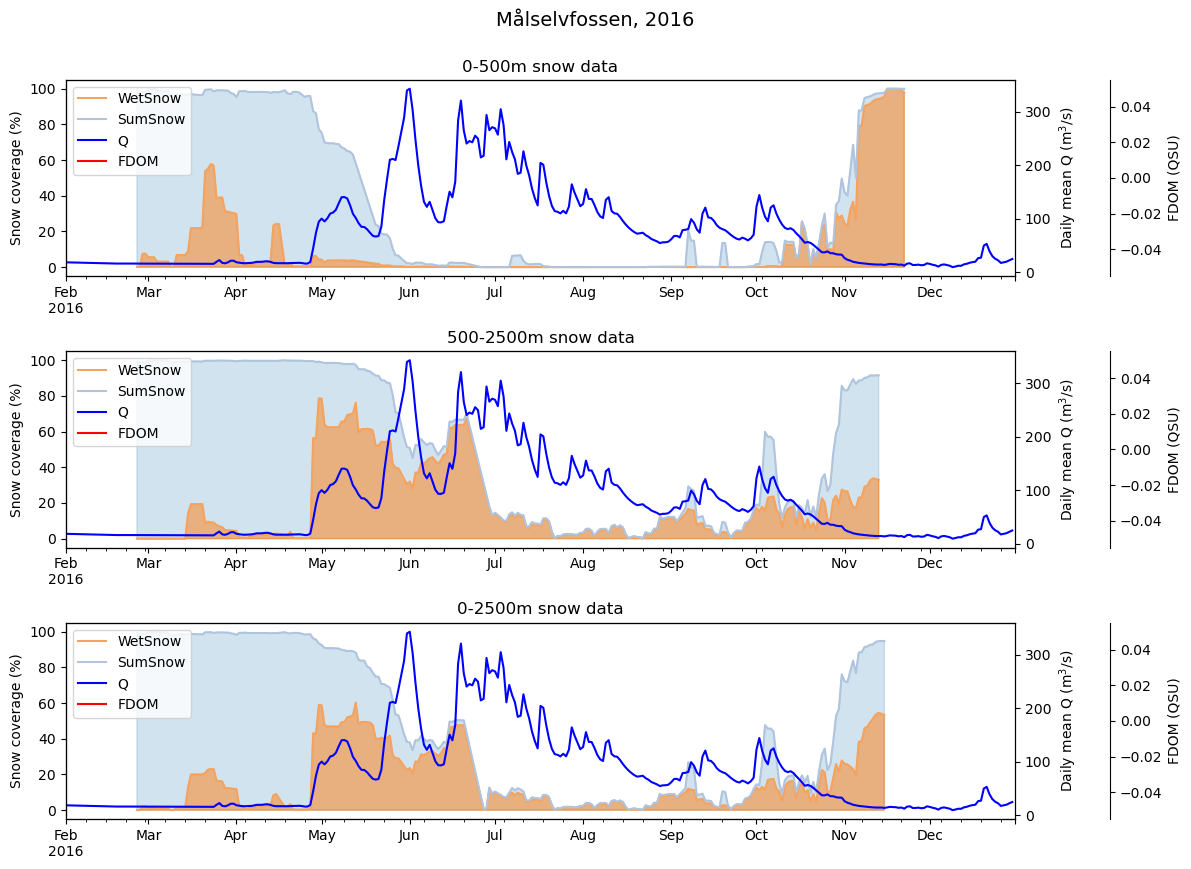

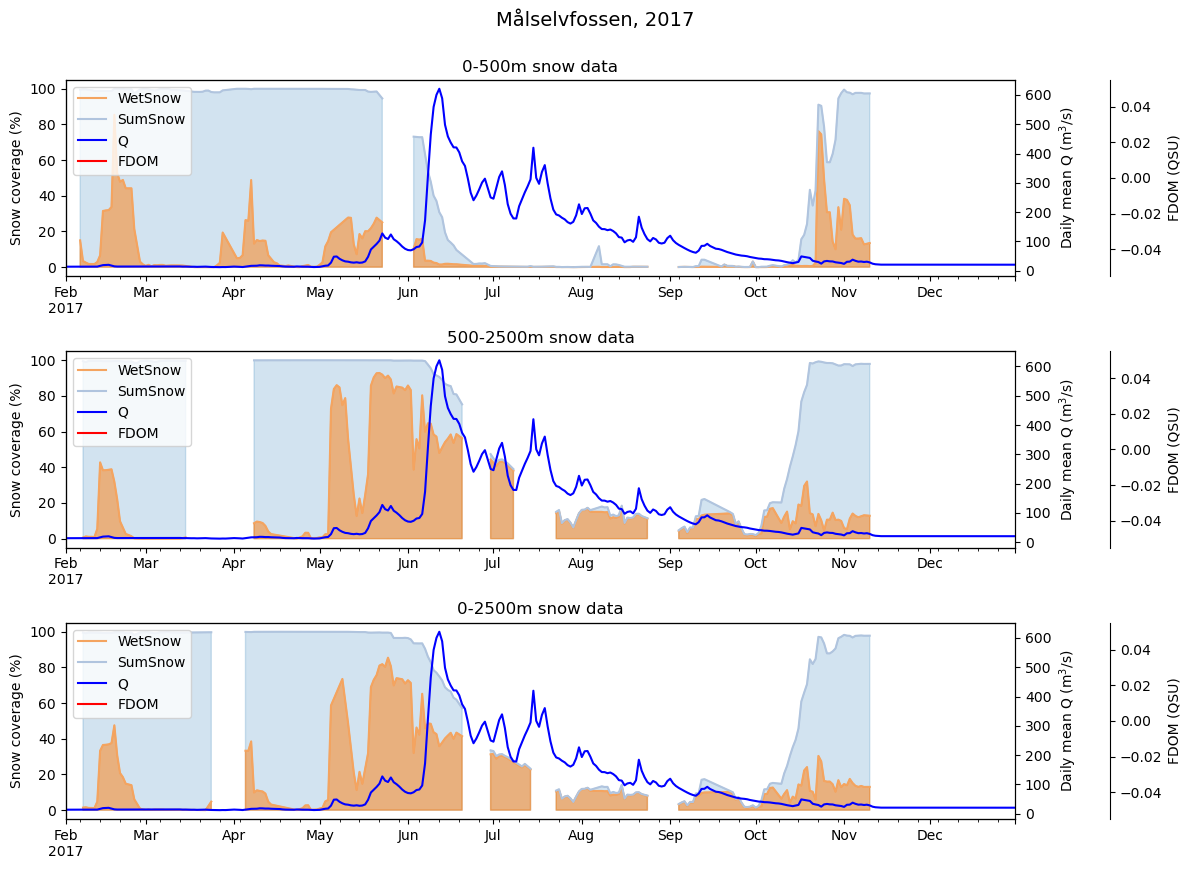

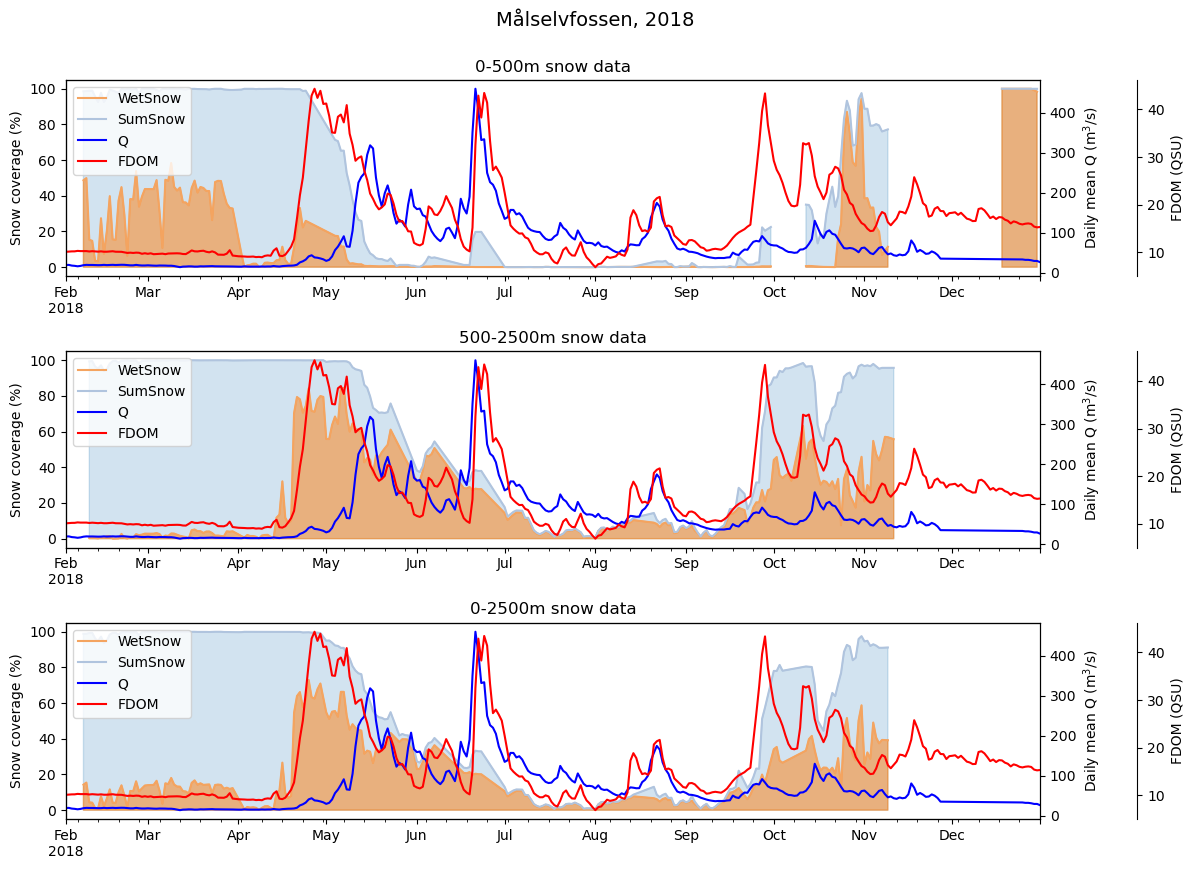

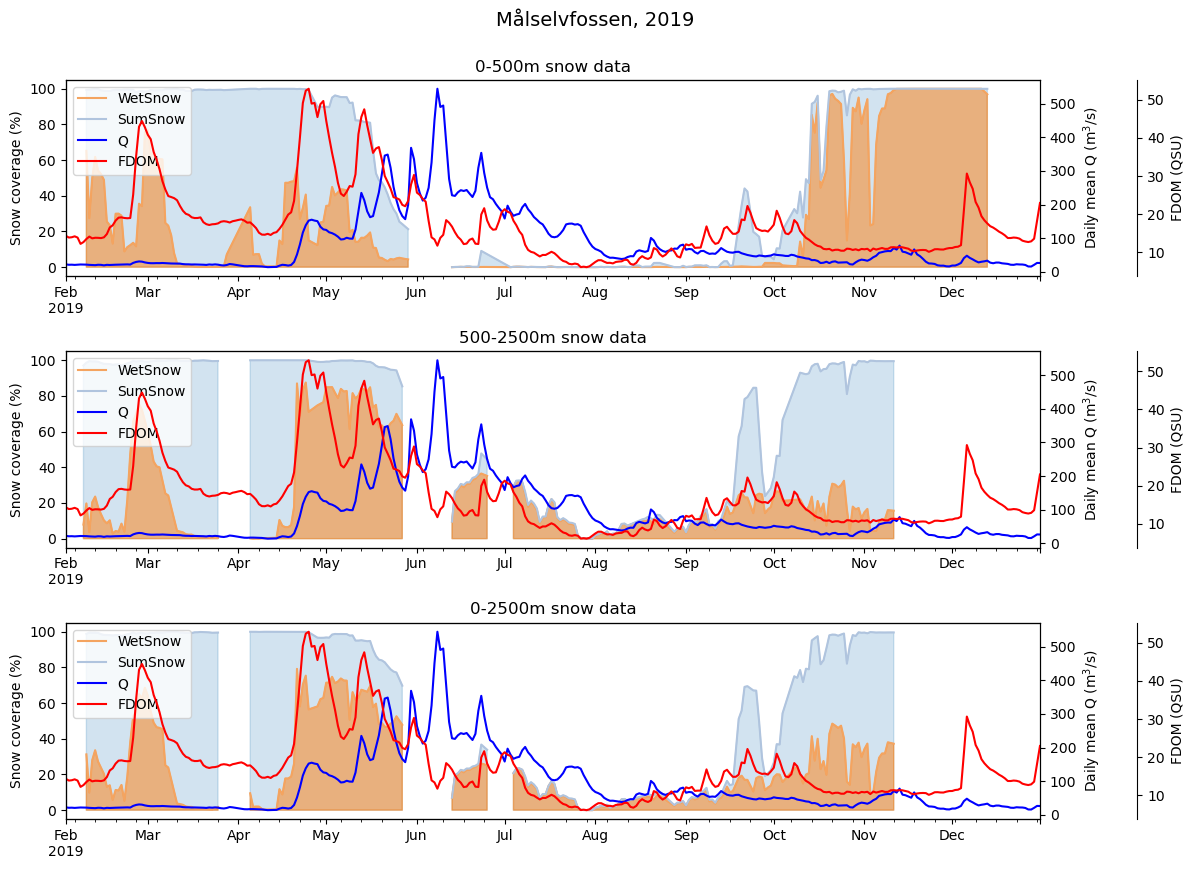

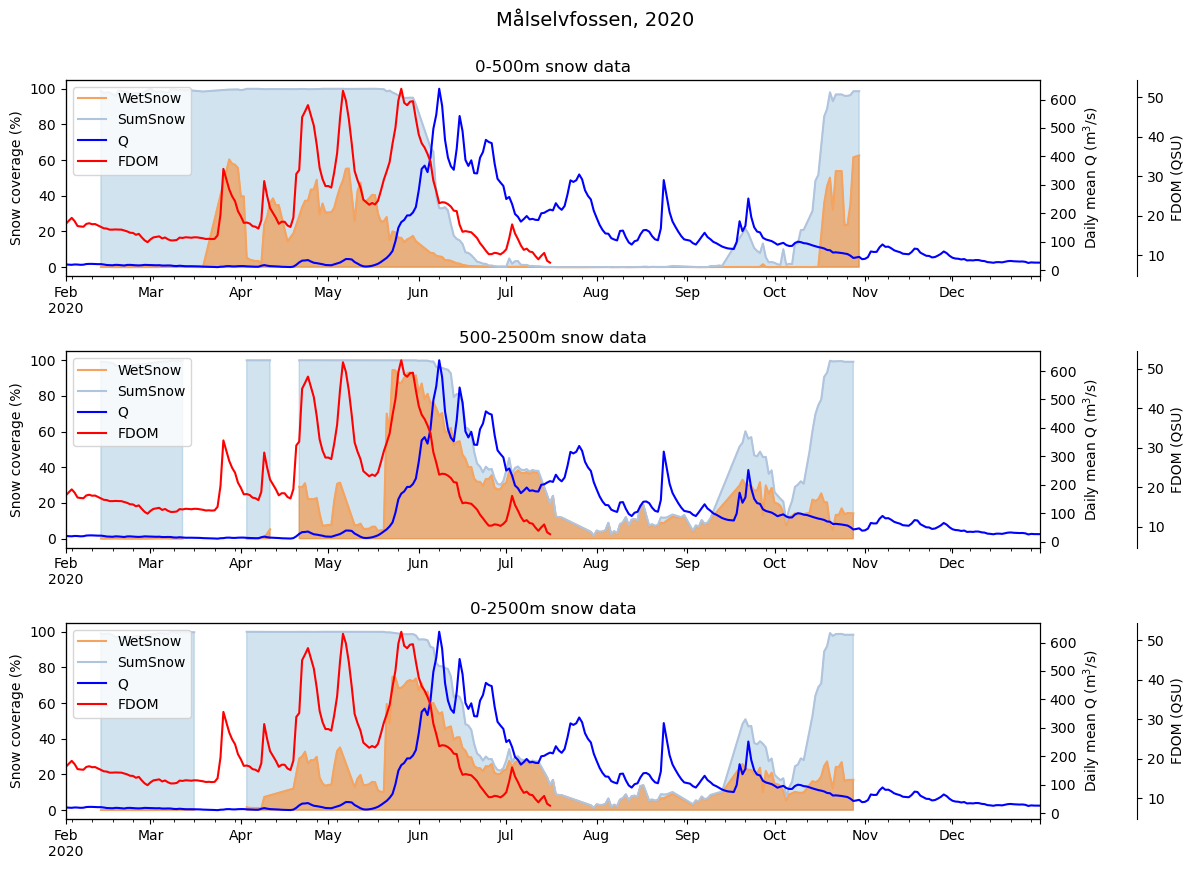

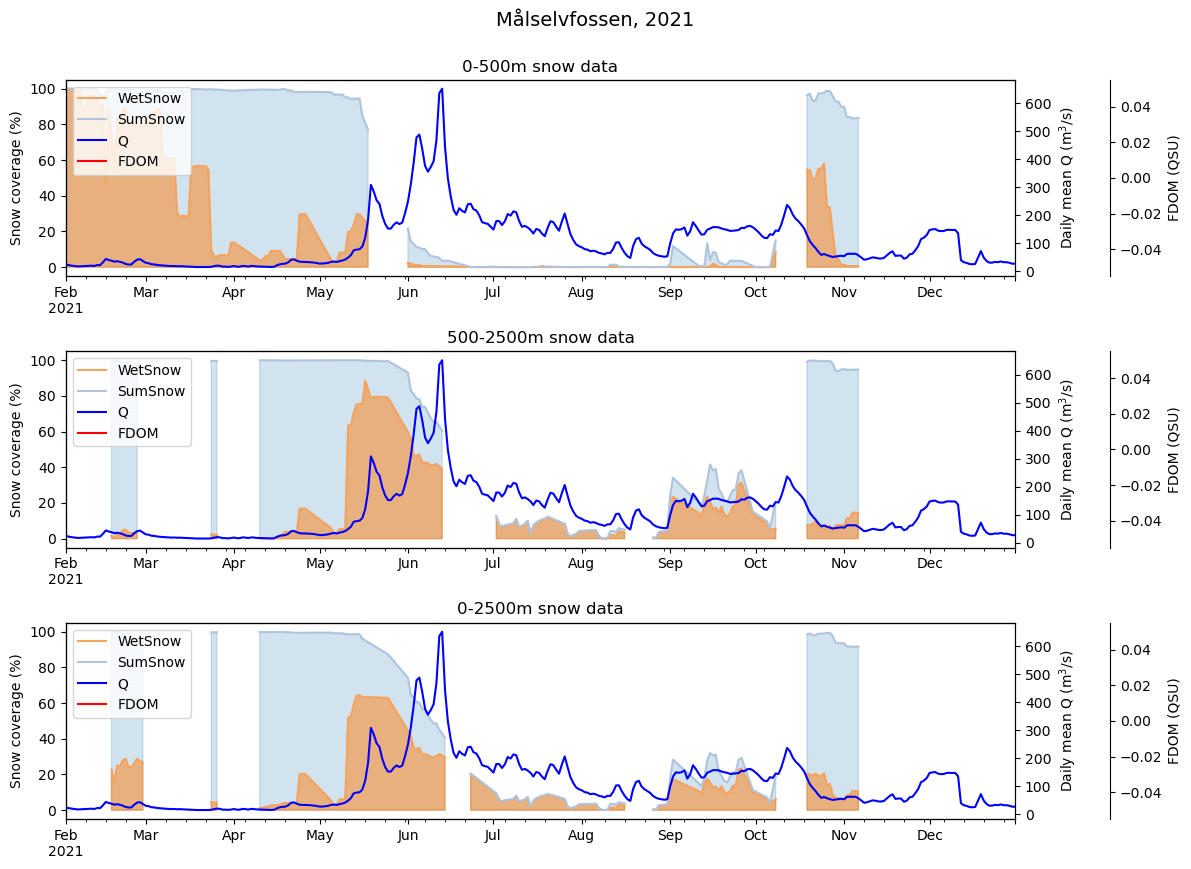

In [111]:
# Plot year by year

# Years to plot for
yr_list = list(range(2015, 2022))
# fig_size = (12, 25)
# yr_list = [2018]
fig_size = (12, 9)


# Snow variables you want to plot
# snow_vars = ['WetSnow', 'DrySnow', 'SumSnow']
# snow_vars = ['WetSnow', 'DrySnow']
snow_vars = ['WetSnow', 'SumSnow']
# snow_vars = ['SumSnow']

# Sort title to use in file name
if len(snow_vars) == 1:
    snow_title = "SumSnow"
elif len(snow_vars) < 3:
    snow_title = "SumWetSnow"
else:
    snow_title = "AllSnowVars"

for i, year in enumerate(yr_list):

    fig = plt.figure(figsize=fig_size)

    # Loop through altitude bands
    for j, band in enumerate(['0-500', '500-2500', '0-2500']):

        df = join_dict[band]

        # Select data for current year. Start in Feb, as no satellite data
        # before then in the dark season
        df_yr = df.loc['%s-02-01' % year: '%s-12-31' % year]

        # Create subplot
        ax1 = fig.add_subplot(3, 1, j+1)

        # Plot snow
        ax1.fill_between(df['SumSnow'].index, df['SumSnow'].values,
                         color='C0', alpha=0.2)
        ax1.fill_between(df['WetSnow'].index, df['WetSnow'].values,
                         color='C1', alpha=0.5)

        df_yr[snow_vars].plot(color=['sandybrown', 'lightsteelblue'],
                              legend=False, ax=ax1)

        # Plot Q
        ax2 = df_yr['Q'].plot(secondary_y=True, ax=ax1,
                              color='b', legend=False, mark_right=False)

        # Plot FDOM
        ax3 = ax1.twinx()
        ax3.spines.right.set_position(("axes", 1.1))
        df_yr['FDOM'].plot(ax=ax3, color='r')

        # Label axes
        ax1.set_ylabel('Snow coverage (%)')
        ax2.set_ylabel('Daily mean Q (m$^3$/s)')
        ax3.set_ylabel("FDOM (QSU)")
        plt.xlabel('')

        # # Turn off x tick labels for all but the last plot
        # if j < 2:
        #     frame1 = plt.gca()
        #     frame1.axes.xaxis.set_ticklabels([])

        ax1.set_title(f"{band}m snow data", size=12)

        # Sort out the legend (complicated a bit by having the second axis)
        l1 = ax1.get_lines()
        l2 = ax2.get_lines()
        l3 = ax3.get_lines()
        lns = l1+l2+l3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc='upper left')

    # # Plot fjord ice cover
    # ax4 = fig.add_subplot(4, 1, 4)
    # df_yr['IceArea (km2)'].plot(ax=ax4, color='lightseagreen', legend=False)
    # ax4.set_ylabel('Fjord ice area (km$^2$)')

    fig.suptitle(f"Målselvfossen, {year}", size=14)
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    plt.savefig(f'../figures/Målselvfossen_QFDOM_{snow_title}_{year}_{chosen_thresh}%.png')

### Some interpretations

**Snow and discharge data**

* 0-500m:
    * The wet snow peak in the 0-500m range happens early, and you only tend to get the discharge peak when the wet snow peak has almost passed (or down to around <~20%)
    * Dry snow hangs around longer than wet snow at this altitude (icey)
    * i.e. the start of the big river flow peak tends to coincide with the end of the wet snow peak, and the time when % snow cover starts to drop below 95%'ish.
* 500-2500m:
   * Get a sudden drop in dry snow coverage and a sudden increase in wet snow coverage about the time when the river discharge starts to increase due to snowmelt
   * % total snow cover starts to drop down from 100% at or just before the time of the first big river flow peak.
   
**Snow and FDOM**
It's hard to draw generalities with only 3 years of data. Here are the broad observations per year:

* 2018: all altitudes get wet snow around the same time in mid-April. Oddly, the 0-500m band has less % wet snow than the higher elevation band (mistake? Icy?). Get a big FDOM peak then (just after this big wetting up of the snow). FDOM increases much more quickly than Q, peaking around two weeks before Q peaks. All the 0-500m snow then disappears, more rapidly than FDOM drops down, and is gone by around mid-May. The FDOM doesn't drop down until a bit later, around the start of June. So from mid-May, all snowmelt inputs are from higher in the catchment, and tend to provide lower-FDOM. The next big FDOM peak is in July, and is probably a big rainfall event more than snowmelt (although this contriutes too).

* 2019: The first FDOM peak is at the start of March, and corresponds with snow at all altitudes wetting up (and just a tiny increase in Q). The next big FDOM peak is at the end of April, and coincides with the 500-2500m band going from 0 to nearly 85% wet, and is just after a smaller wetting up of the 0-500m band. This time, the FDOM and Q peak coincide in terms of timing. Hard to see what drives the third FDOM peak aside from an increase in Q (rainfall event, then?). After the 3rd peak the total snow coverage at 0-500m drops steadily down to 0, and FDOM also drops down too. Either because 0-500m isn't contributing any more and had more FDOM, or because it's diluted by the melting of 0-500m (and above??).

* 2020: This is a nice year. There are 5 spring peaks in FDOM between April and June, firstly two smaller ones, then three larger ones. The firt two correspond to snow wetting events at 0-500m, accompanied by almost indiscernible increases in Q. The snow data therefore provides a very nice validation of the sensor data. There is no data on whether the first of these snow wetting events happened at higher elevations, but the second did not. The third and fourth FDOM peaks, which were higher than the first two, are accompanied by wetting at all elevations, but more so lower down than higher up. The fifth FDOM peak corresponds with the melting of 0-500m snow entirely (which dropped from 100-0% over this FDOM event), peaking around 2 weeks before the first big discharge peak of the season. As discharge rises up towards its first big peak of the season, we therefore see FDOM in fact decreasing.

**Next steps:**
To discuss, but ideas would be:
* Spend a little bit of time cleaning the remote sensing data. e.g. Interpolate some of the shorter gaps, and remove the odd artefact (e.g. 2019, see dodgy drop in spring snow cover that's clearly an artefact)
* Only focus on timing of snow melt and corresponding discharge, as autumn snow cover can be 100% and yet when it melts causes only a very small flow peak
* Think about how to come up with a statistical relationship between snow cover and flow.